In [667]:
%load_ext autoreload
%autoreload 2

In [666]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, 
                                   RobustScaler)
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from geopy.distance import geodesic

%matplotlib inline

In [384]:
y = pd.read_csv('data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
X = pd.read_csv('data/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
final_test = pd.read_csv('data/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')

In [385]:
X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [386]:
y.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [387]:
# check if 'id' column in both X_train and y_train line up correctly
(X.id.values == y.id.values).all()

True

In [388]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [389]:
X.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [390]:
X[['subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward']].head()

,subvillage,region,region_code,district_code,lga,ward
0,Mnyusi B,Iringa,11,5,Ludewa,Mundindi
1,Nyamara,Mara,20,2,Serengeti,Natta
2,Majengo,Manyara,21,4,Simanjiro,Ngorika
3,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu
4,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi


In [391]:
# Looking at groups of features with names that indicate they may belong to the same categories

In [392]:
X[['scheme_management', 'scheme_name', 'management', 'management_group']].head()

,scheme_management,scheme_name,management,management_group
0,VWC,Roman,vwc,user-group
1,Other,NaN,wug,user-group
2,VWC,Nyumba ya mungu pipe scheme,vwc,user-group
3,VWC,NaN,vwc,user-group
4,NaN,NaN,other,other


In [393]:
X[X.scheme_management.str.lower() != X.management.str.lower()]\
       [['scheme_management', 'scheme_name', 'management', 'management_group', 'recorded_by']].head(10)

,scheme_management,scheme_name,management,management_group,recorded_by
1,Other,NaN,wug,user-group,GeoData Consultants Ltd
4,NaN,NaN,other,other,GeoData Consultants Ltd
7,NaN,NaN,wug,user-group,GeoData Consultants Ltd
9,NaN,NaN,vwc,user-group,GeoData Consultants Ltd
18,NaN,NaN,vwc,user-group,GeoData Consultants Ltd
23,Water authority,Mashangwi,vwc,user-group,GeoData Consultants Ltd
27,NaN,NaN,vwc,user-group,GeoData Consultants Ltd
31,WUA,Chalinze wate,private operator,commercial,GeoData Consultants Ltd
35,NaN,NaN,vwc,user-group,GeoData Consultants Ltd
54,NaN,NaN,private operator,commercial,GeoData Consultants Ltd


In [394]:
# There seem to be a lot f entries recorded by the same entity

X.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [395]:
# We can eliminate columns without variance by looking at the number of unique values they have

In [396]:
for col in X.columns:
    if X[col].nunique() <= 1:
        print(col)

# The whole training dataset is recorded by the same entity 
# --> this feature lack variance --> probably don't need it for modeling

recorded_by


### Concat X and y into 1 dataframe

In [397]:
df = pd.concat([X, y], axis=1)

In [398]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,69572,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,8776,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,34310,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,67743,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,19728,functional


In [399]:
# drop 'id' column
df2 = df.drop('id', axis=1).copy()

In [400]:
df2.duplicated().sum()

36

In [401]:
# If we're removing the 'id' columns, there're 36 entries with the exact same information 
# as at least 1 other entry (duplicated)
# --> I'll remove these

In [402]:
df2.drop_duplicates(keep='first', inplace=True)

In [403]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59364 non-null  float64
 1   date_recorded          59364 non-null  object 
 2   funder                 55729 non-null  object 
 3   gps_height             59364 non-null  int64  
 4   installer              55709 non-null  object 
 5   longitude              59364 non-null  float64
 6   latitude               59364 non-null  float64
 7   wpt_name               59364 non-null  object 
 8   num_private            59364 non-null  int64  
 9   basin                  59364 non-null  object 
 10  subvillage             58993 non-null  object 
 11  region                 59364 non-null  object 
 12  region_code            59364 non-null  int64  
 13  district_code          59364 non-null  int64  
 14  lga                    59364 non-null  object 
 15  wa

In [404]:
df2.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3314
recorded_by                  0
scheme_management         3877
scheme_name              28139
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [23]:
df2.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59364.000000,59364.000000,59364.000000,5.936400e+04,59364.000000,59364.000000,59364.000000,59364.000000,59364.000000
mean,317.843017,668.702513,34.097560,-5.709463e+00,0.474429,15.295516,5.631494,180.019086,1301.441227
std,2998.473133,693.131013,6.517065,2.943608e+00,12.239934,17.592619,9.636138,471.604294,951.369704
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.095187,-8.541904e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,370.000000,34.910318,-5.023822e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1320.000000,37.179490,-3.326918e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [24]:
# Distribution of the different values in `status_group`
df2.status_group.value_counts()

functional                 32237
non functional             22813
functional needs repair     4314
Name: status_group, dtype: int64

In [25]:
df2.water_quality.value_counts()

soft                  50785
salty                  4856
unknown                1873
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [26]:
df2.quality_group.value_counts()

good        50785
salty        5195
unknown      1873
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [27]:
df2[df2.quality_group == 'good'].water_quality.value_counts()

soft    50785
Name: water_quality, dtype: int64

In [28]:
# So only wells with water quality = 'soft' is considered 'good'

In [29]:
df2[df2.status_group.isin(['functional', 'functional needs repair'])].quality_group.value_counts()

good        32639
salty        2691
milky         452
colored       300
unknown       299
fluoride      170
Name: quality_group, dtype: int64

In [30]:
df2.quantity.value_counts()

enough          33165
insufficient    15119
dry              6243
seasonal         4048
unknown           789
Name: quantity, dtype: int64

In [31]:
df2.quantity_group.value_counts()

enough          33165
insufficient    15119
dry              6243
seasonal         4048
unknown           789
Name: quantity_group, dtype: int64

In [32]:
df2[~(df2.quantity == df2.quantity_group)]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group


In [33]:
# 'quantity' & 'quantity_group' stores the same information 
# --> it's okay to drop 1 of them

In [34]:
df2[df2.status_group.isin(['functional', 'functional needs repair'])].quantity.value_counts()

enough          24033
insufficient     9358
seasonal         2739
unknown           227
dry               194
Name: quantity, dtype: int64

In [35]:
df2.management_group.value_counts()

user-group    52456
commercial     3638
parastatal     1766
other           943
unknown         561
Name: management_group, dtype: int64

In [36]:
# not too sure what 'num_private' indicates
df2.num_private.value_counts()

0      58607
6         81
1         73
8         46
5         46
       ...  
42         1
136        1
35         1
131        1
94         1
Name: num_private, Length: 65, dtype: int64

## Visualizing geospatial data 

### Scatter plot

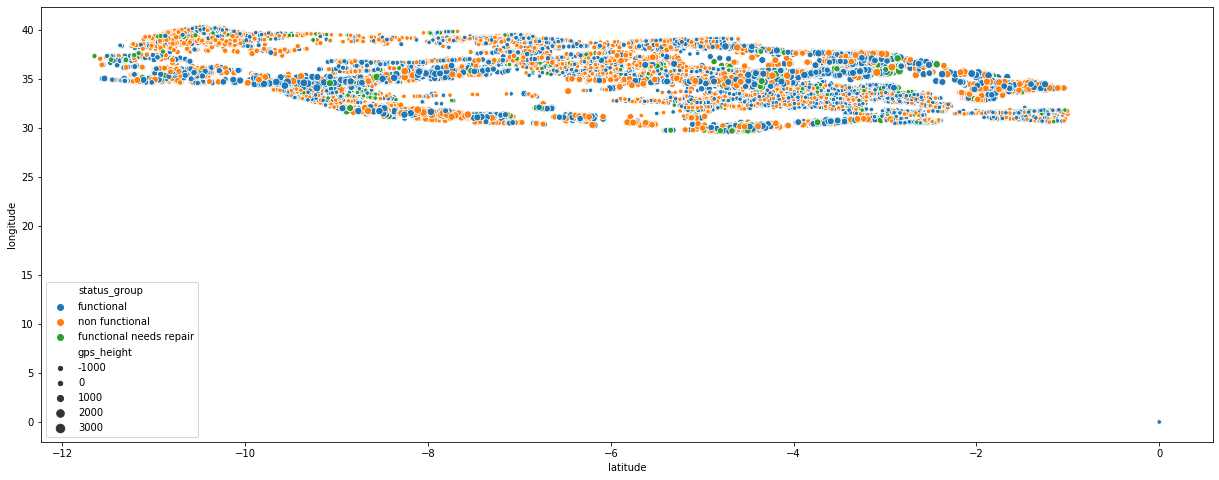

In [38]:
fig, ax = plt.subplots(figsize=(21,8))
sns.scatterplot(data=df2, x='latitude', y='longitude', size='gps_height', hue='status_group', ax=ax);

In [39]:
# Realistically, longitude of places in Tanzania should not go below 30
# Therefore longitude = 0 is most likely just placeholder for entries without that information

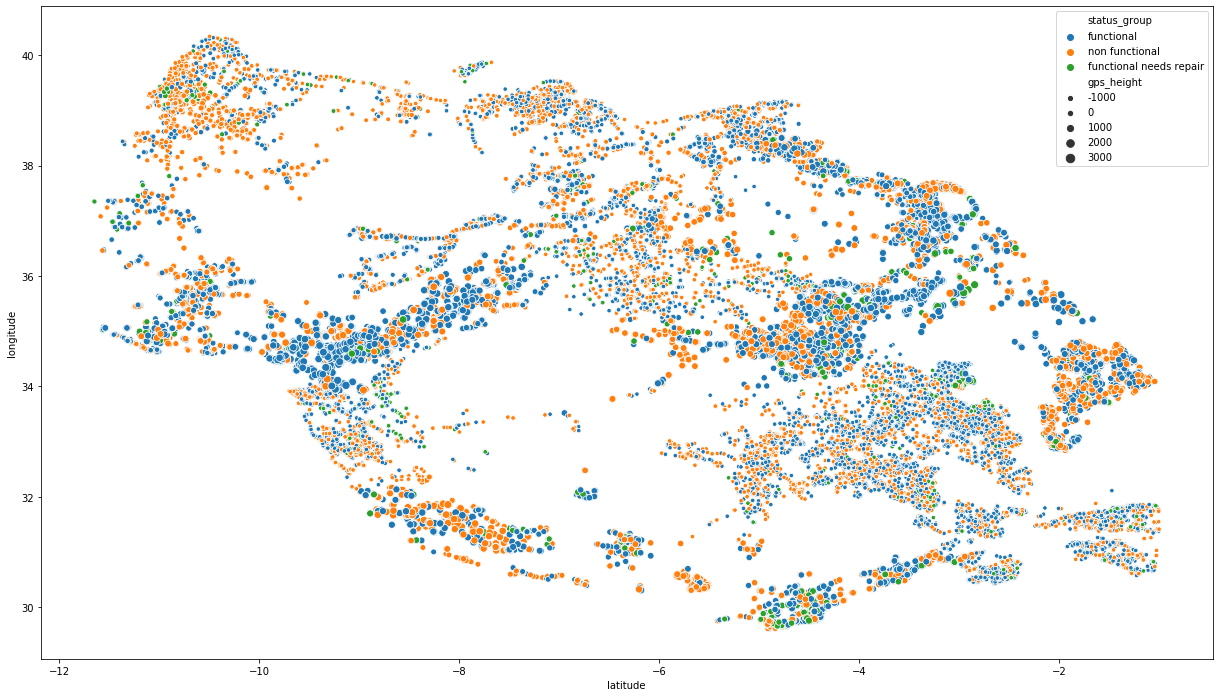

In [40]:
fig, ax = plt.subplots(figsize=(21,12))
sns.scatterplot(data=df[df.longitude >= 25], x='latitude', y='longitude', 
                size='gps_height', hue='status_group', ax=ax);

In [41]:
# It looks like wells with higher value for 'gps_height' are more likely to be functional

In [42]:
altitude_bins = np.linspace(df2.gps_height.min()-1, df2.gps_height.max()+1, 5)

In [43]:
altitude_bins

array([ -91. ,  624.5, 1340. , 2055.5, 2771. ])

In [44]:
df2['gps_binned'] = pd.cut(df2.gps_height, bins=altitude_bins)

In [45]:
pd.crosstab(df2.gps_binned, df2.status_group, normalize='index')\
    .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
gps_binned,,,
"(2055.5, 2771.0]",0.823469,0.023469,0.153061
"(1340.0, 2055.5]",0.638663,0.060691,0.300646
"(624.5, 1340.0]",0.530925,0.091117,0.377958
"(-91.0, 624.5]",0.500630,0.071813,0.427557


### Folium

In [ ]:
!conda install folium -c conda-forge

In [46]:
import folium

In [49]:
df2.loc[0].longitude

34.93809275

In [51]:
tanzania = folium.Map(location=[-6.3728, 34.8925], zoom_start=8)

In [56]:
for idx, well in df2.iterrows():
    location = [well['latitude'], well['longitude']]
    folium.CircleMarker(location=location).add_to(tanzania)
    
# tanzania

In [53]:
tanzania.save("map_tanzania.html")

In [54]:
# Folium visualization doesn't look too helpful...

Since the scales of the 2 variables longitude and latitude are different, I'll normalize them first for modeling later.

### Contingency tables between some categorical variables and target variable `status_group`

In [83]:
pd.crosstab(df2.region, df2.status_group, normalize='index').sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
region,,,
Iringa,0.782206,0.023234,0.194560
Arusha,0.684776,0.052239,0.262985
Manyara,0.623500,0.060644,0.315856
Kilimanjaro,0.602877,0.073533,0.323590
Pwani,0.590512,0.013662,0.395825
Dar es Salaam,0.572671,0.003727,0.423602
Tanga,0.563801,0.028661,0.407538
Ruvuma,0.560606,0.062121,0.377273
Shinyanga,0.559839,0.127309,0.312851


In [84]:
pd.crosstab(df2.extraction_type_class, df2.status_group, normalize='index')\
    .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
extraction_type_class,,,
rope pump,0.649667,0.037694,0.312639
handpump,0.630340,0.060424,0.309237
gravity,0.599268,0.100837,0.299895
submersible,0.538723,0.040992,0.420285
wind-powered,0.427350,0.059829,0.512821
motorpump,0.379980,0.046200,0.573820
other,0.160106,0.032052,0.807842


In [85]:
pd.crosstab(df2.quantity, df2.status_group, normalize='index')\
    .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
quantity,,,
enough,0.652344,0.072305,0.275351
seasonal,0.574111,0.102520,0.323370
insufficient,0.523050,0.095906,0.381044
unknown,0.269962,0.017744,0.712294
dry,0.025148,0.005927,0.968925


In [86]:
pd.crosstab(df2.water_quality, df2.status_group, normalize='index')\
    .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
water_quality,,,
fluoride,0.755000,0.065000,0.180000
soft,0.565876,0.076814,0.357310
milky,0.544776,0.017413,0.437811
salty abandoned,0.513274,0.212389,0.274336
coloured,0.502041,0.110204,0.387755
salty,0.457166,0.046334,0.496499
fluoride abandoned,0.352941,0.000000,0.647059
unknown,0.140950,0.018687,0.840363


### Visualization using stacked bar charts

### `quantity`

In [283]:
quantity_tab = pd.crosstab(df2.quantity, df2.status_group, normalize='index')\
                    .sort_values(by='functional')
quantity_tab

status_group,functional,functional needs repair,non functional
quantity,,,
dry,0.025148,0.005927,0.968925
unknown,0.269962,0.017744,0.712294
insufficient,0.523050,0.095906,0.381044
seasonal,0.574111,0.102520,0.323370
enough,0.652344,0.072305,0.275351


In [210]:
# Reference: https://towardsdatascience.com/stacked-bar-charts-with-pythons-matplotlib-f4020e4eb4a7
# (by percentage)
def plot_stackedbar_p(df, colors, title, figsize):
    colors = ['#5886a5', '#FAC748', '#ff6361']

    fields = list(df.columns)
    
    fig, ax = plt.subplots(1, figsize=figsize)
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left=left, color=colors[idx], height=0.3)
        left = left + df[name]
        
    # title and subtitle
    plt.title(title, loc='left', fontsize=20, pad=40)
    # legend
    plt.legend(labels, bbox_to_anchor=([0.38, 1.1, 0.58, 0]), ncol=3, frameon=True, fontsize=14)
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # format x ticks
    xticks = np.arange(0,1.1,0.1)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    plt.xticks(xticks, xlabels)
    # adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    # reset font size for yticks
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [247]:
# colors = ['#1D2F6F', '#6EAF46', '#FAC748']
colors = ['#5886a5', '#FAC748', '#ff6361']
# colors = ['#006d90', '#488f31', '#ffa600']

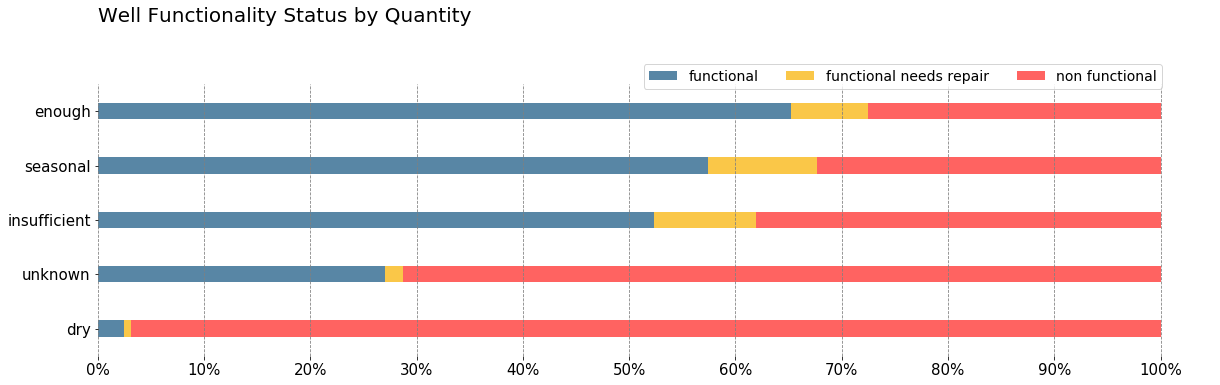

In [285]:
title = 'Proportion of Well Functionality Statuses Grouped by Quantity\n'

plot_stackedbar_p(quantity_tab, colors, title, (20,5))

In [297]:
def plot_stackedbar(df, colors, title, figsize):
    fields = list(df.columns)
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=figsize)
# plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left=left, color=colors[idx], height=0.3)
        left = left + df[name]
# title and subtitle
    plt.title(title, loc='left', fontsize=20, pad=40)
# legend
    plt.legend(labels, bbox_to_anchor=([0.38, 1.1, 0.58, 0]), ncol=3, frameon=True, fontsize=14)
# remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# format x ticks
#     xticks = np.arange(0,1.1,0.1)
#     xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
#     plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
# reset font size for yticks
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

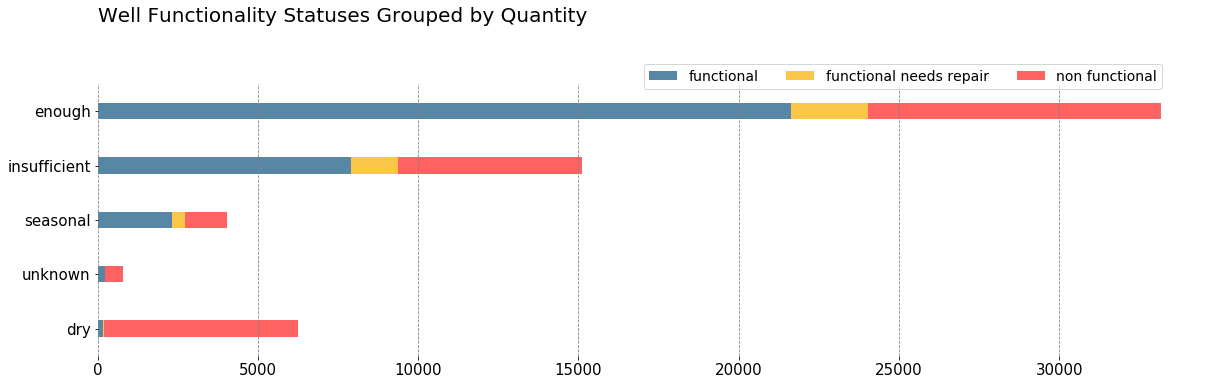

In [326]:
test = pd.crosstab(df2.quantity, df2.status_group).sort_values(by='functional')
title = 'Well Functionality Statuses Grouped by Quantity\n'

plot_stackedbar(test, colors, title, (20,5))

### `region`

In [286]:
region_tab = pd.crosstab(df2.region, df2.status_group, normalize='index')\
                .sort_values(by='functional')

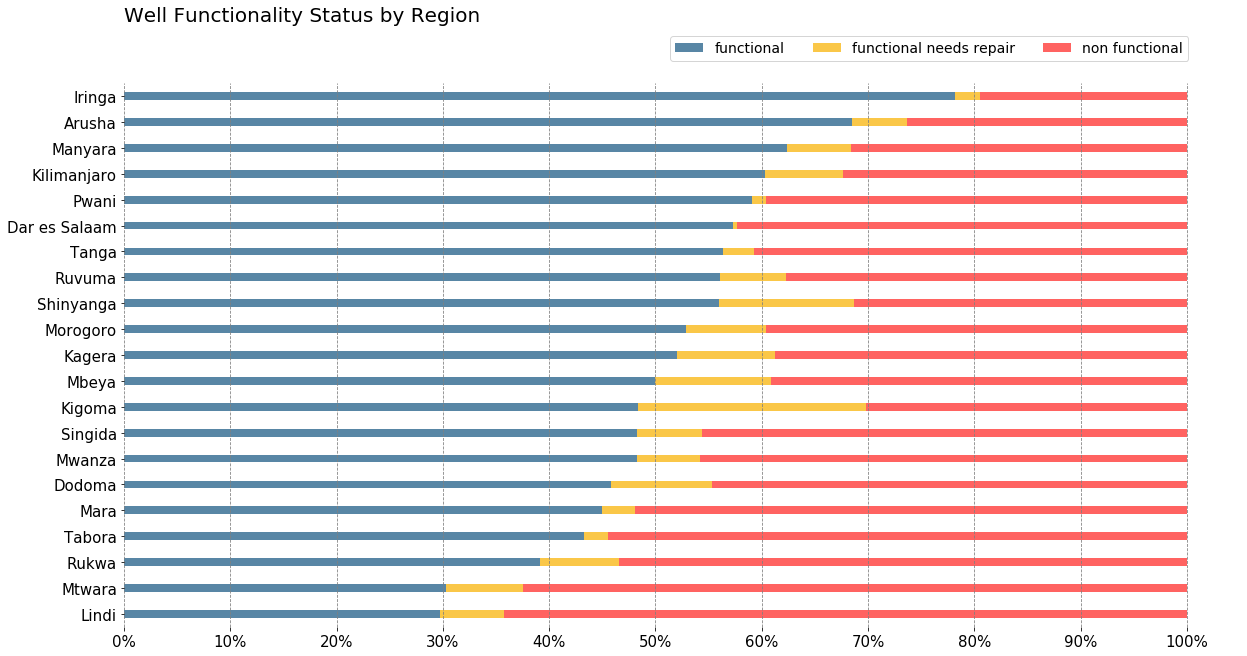

In [287]:
title = 'Well Functionality Status by Region\n'

plot_stackedbar_p(region_tab, colors, title, (20,10))

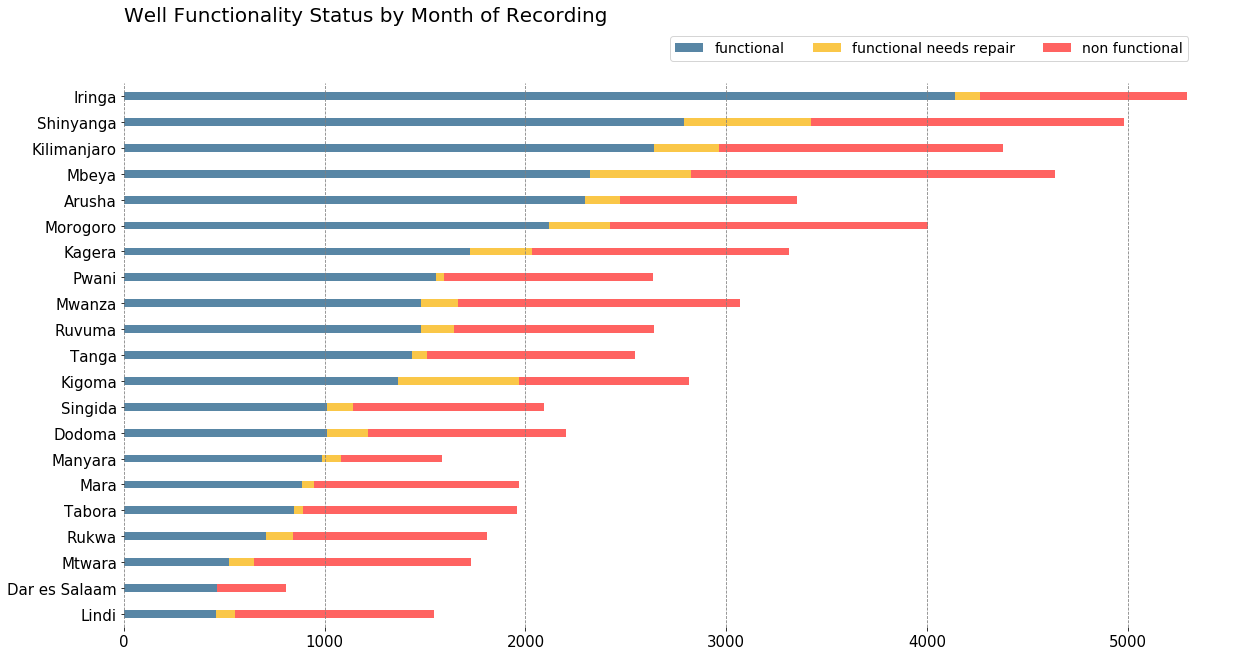

In [302]:
region_tab2 = pd.crosstab(df2.region, df2.status_group).sort_values(by='functional')

plot_stackedbar(region_tab2, colors, title, (20,10))

### `water_quality`

In [310]:
quality_tab = pd.crosstab(df2.water_quality, df2.status_group).sort_values(by='functional')

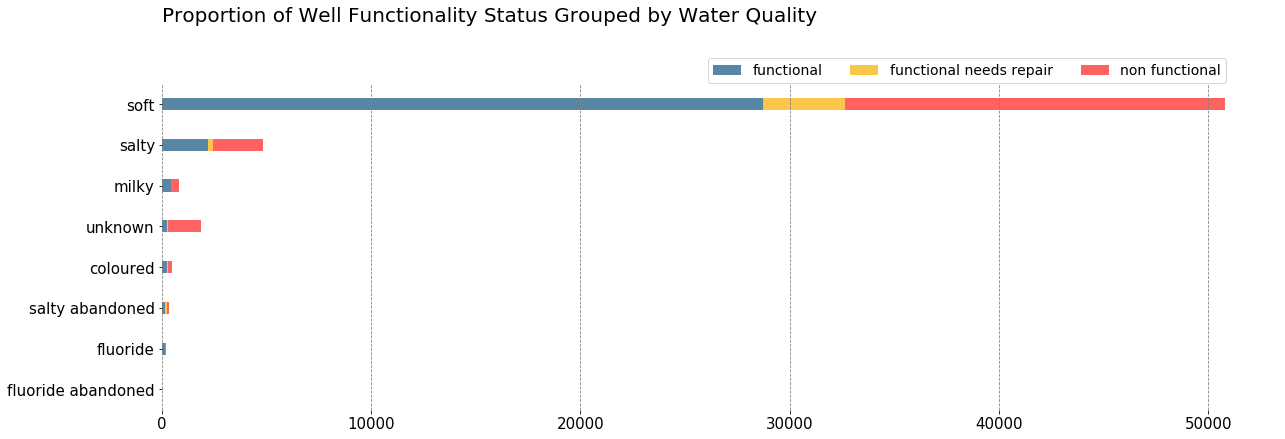

In [311]:
title = 'Proportion of Well Functionality Status Grouped by Water Quality\n'

plot_stackedbar(quality_tab, colors, title, (20,6))

### `extraction_type`

In [312]:
extract_tab = pd.crosstab(df2.extraction_type_class, df2.status_group).sort_values(by='functional')
extract_tab

status_group,functional,functional needs repair,non functional
extraction_type_class,,,
wind-powered,50,7,60
rope pump,293,17,141
other,1029,206,5192
motorpump,1135,138,1714
submersible,3325,253,2594
handpump,10359,993,5082
gravity,16046,2700,8030


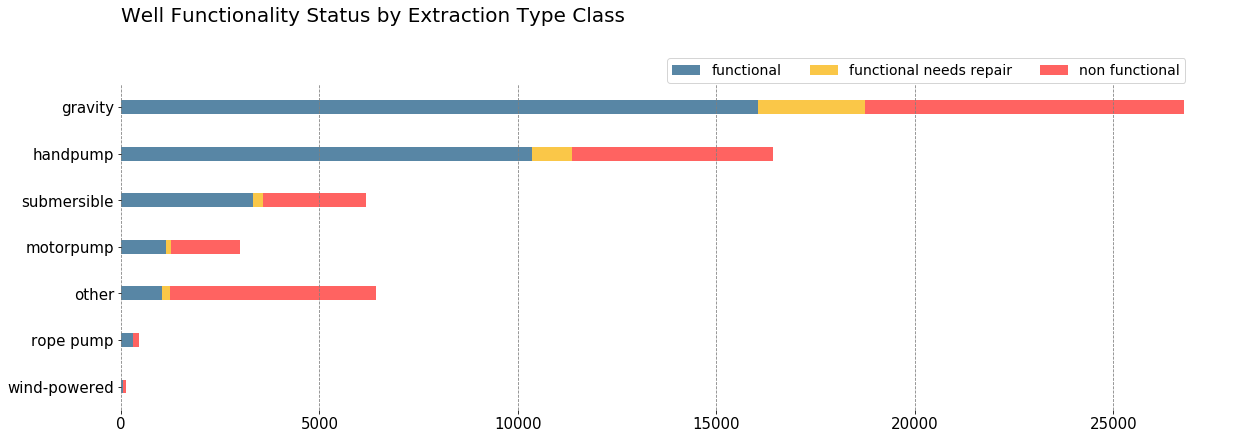

In [327]:
title = 'Well Functionality Status by Extraction Type Class\n'

plot_stackedbar(extract_tab, colors, title, (20,6))

### `basin`

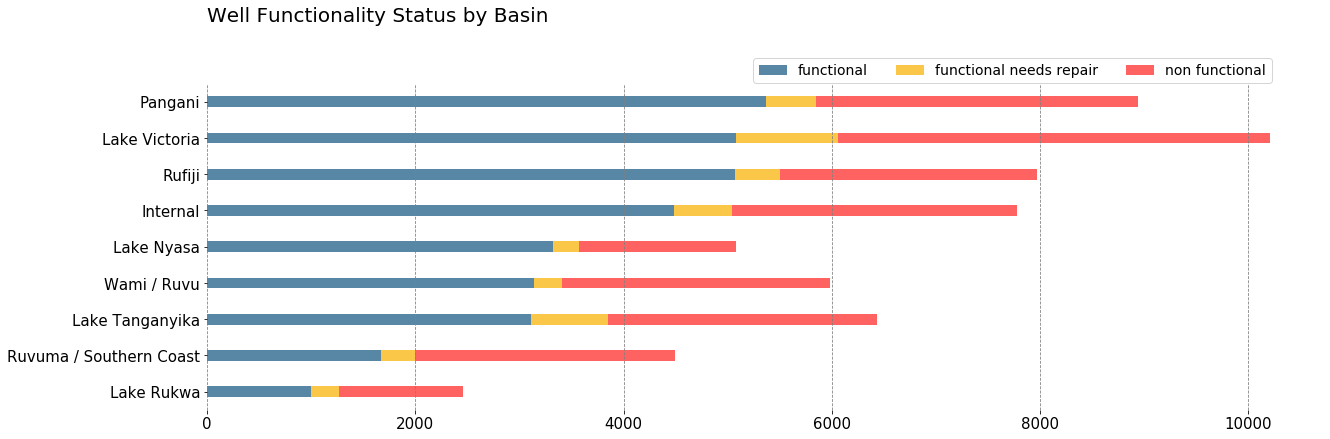

In [349]:
basin_tab = pd.crosstab(df2.basin, df2.status_group).sort_values(by='functional')

title = 'Well Functionality Status by Basin\n'

plot_stackedbar(basin_tab, colors, title, (20,6))

### `waterpoint_type`

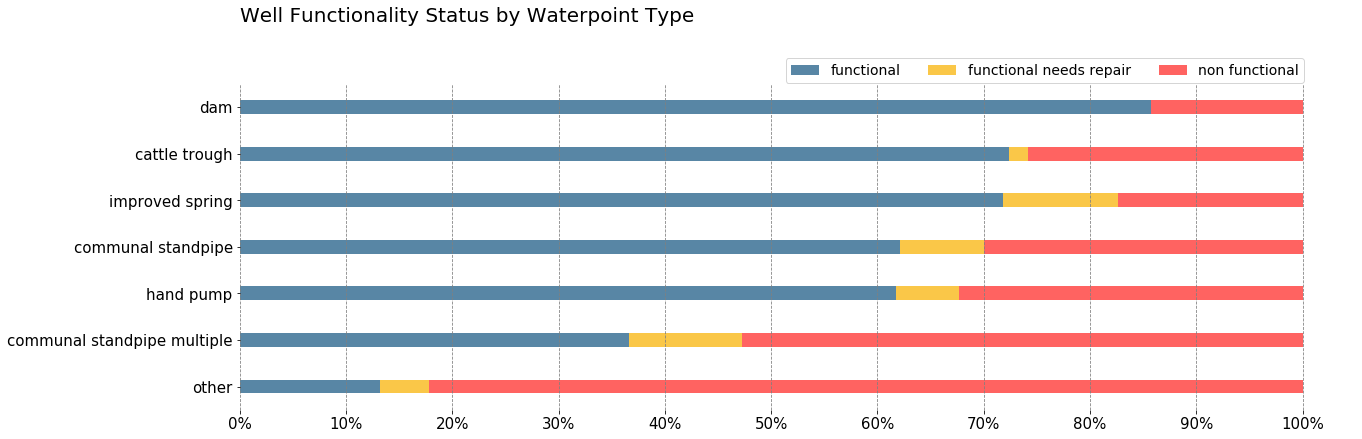

In [351]:
wpt_type_tab = pd.crosstab(df2.waterpoint_type, df2.status_group, normalize='index').sort_values(by='functional')

title = 'Well Functionality Status by Waterpoint Type\n'

plot_stackedbar_p(wpt_type_tab, colors, title, (20,6))

### `date_recorded`

Perhaps the functionality of the wells are also partially impacted by when the inspection/measurement was recorded. I'll extract the month & year from `date_recorded` to create a new column to see if there's any potential relationship between the record date and outcome.

In [512]:
df2.date_recorded = pd.to_datetime(df.date_recorded)

In [513]:
df2['month_recorded'] = df2.date_recorded.dt.month_name().str.slice(stop=3)
df2['year_recorded'] = df2.date_recorded.dt.year 

In [303]:
month_tab = pd.crosstab(df2.month_recorded, df2.status_group).sort_values(by='functional')

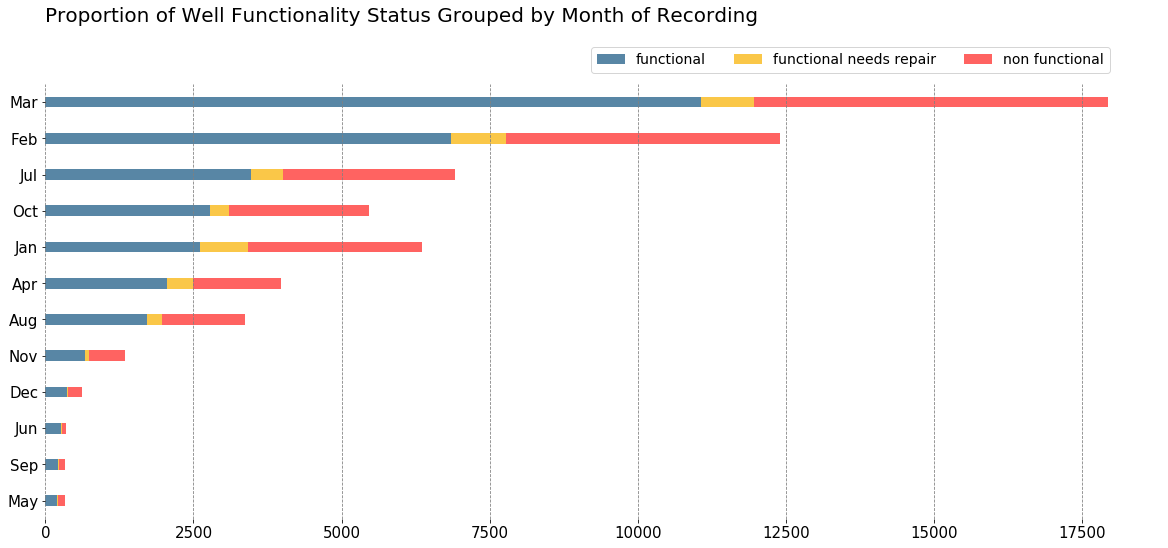

In [304]:
title = 'Proportion of Well Functionality Status Grouped by Month of Recording\n'

plot_stackedbar(month_tab, colors, title, (20,8))

In [308]:
year_tab = pd.crosstab(df2.year_recorded, df2.status_group).sort_values(by='functional')
year_tab.index = year_tab.index.astype(str)
year_tab

status_group,functional,functional needs repair,non functional
year_recorded,,,
2002,1,0,0
2004,10,1,19
2012,3120,361,2930
2013,12895,2140,9226
2011,16211,1812,10638


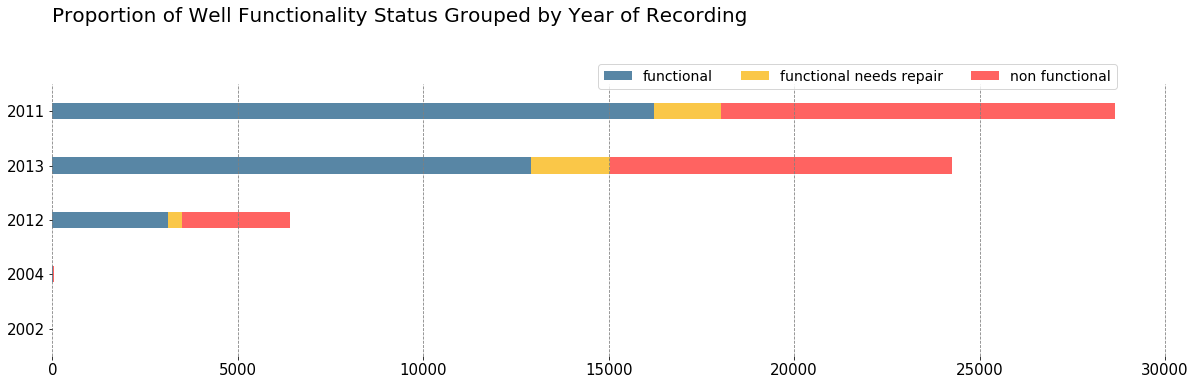

In [309]:
title = 'Proportion of Well Functionality Status Grouped by Year of Recording\n'

plot_stackedbar(year_tab, colors, title, (20,5))

Naturally, we can assume wells functionality would decrease as they get older. I'll add another column called `age_recorded` which is basically the difference between `year_recorded` and `construction_year`.

In [514]:
df2['age_recorded'] = df2.year_recorded - df2.construction_year

In [319]:
age_tab = pd.crosstab(df2.age_recorded, df2.status_group)\
            .sort_values(by='functional', ascending=False)

In [322]:
age_tab

status_group,functional,functional needs repair,non functional
age_recorded,,,
2011,6827,1153,5350
2012,2587,310,2232
3,1949,110,681
1,1754,66,483
2,1600,87,442
...,...,...,...
-4,1,0,1
-7,1,0,0
-2,0,0,1


In [324]:
pd.crosstab(df2.construction_year, df2.status_group)\
            .sort_values(by='functional', ascending=False)

status_group,functional,functional needs repair,non functional
construction_year,,,
0,10533,1786,8354
2010,2023,90,532
2008,1839,127,647
2009,1774,138,621
2000,1279,136,676
2007,1081,116,390
2011,943,78,235
2006,883,135,453
2003,828,71,387


It appears that generally speaking wells' functionality decreases as they get older which makes sense, although according to our dataset, a large amount of wells constructed in 2010 still remain functional compared to other years, which is not totally unreasonable as the most recent entries were only recorded in 2013, 3 years after 2010.

In addition, a large amount of entries have a `construction_year` of 0, which most likely acts like a placeholder for non-available information. I'm not sure if I need to replace these 0 values with anything else, or keep them as is.

Also, somehow it seems like there're a few entries that were "recorded" even before they were constructed, especially in 2004, which seems strange.

In [325]:
df2[df2.year_recorded < df2.construction_year][['date_recorded', 'construction_year', 'status_group']]

,date_recorded,construction_year,status_group
8729,2004-05-01,2008,non functional
10441,2004-12-01,2006,non functional
13366,2004-06-01,2011,functional
23373,2004-03-01,2009,functional
27501,2004-01-07,2009,functional
32619,2004-03-01,2005,non functional
33942,2004-03-01,2007,non functional
39559,2004-03-06,2009,non functional
48555,2004-12-01,2008,functional


In [515]:
# Convert label to numerical using LabelEncoder

le = LabelEncoder()
le.fit(df2.status_group)
le.classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [330]:
# 0 = functional
# 1 = functional needs repair
# 2 = non functional

In [516]:
df2['status_encoded'] = le.transform(df2.status_group)

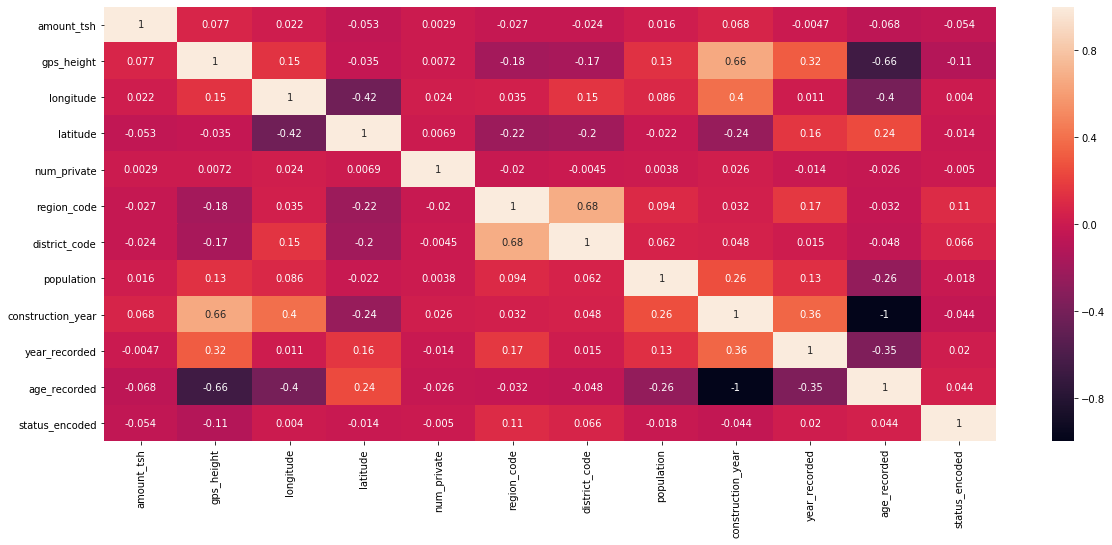

In [341]:
corr = df2.corr()
fig, ax = plt.subplots(1, figsize=(20,8))
ax = sns.heatmap(corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

In [342]:
# Somehow there seems to be some correlation between geospatial data (longitude/latitude/gps_height) and 
# the year/age recorded as well as construction year

# Two of the features with highest correlation with status_encoded are 'gps_height'(negative) 
# and 'region_code'(positive)

# Also, 'year-recorded' also seems to be positively correlated to 'region_code', which may indicates the recording
# were done by regions

## `train_test_split`

In [353]:
df2.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'gps_binned', 'month_recorded', 'year_recorded',
       'age_recorded', 'status_encoded'],
      dtype='object')

In [360]:
X = df2.drop(['recorded_by', 'quantity_group', 'gps_binned', 'status_group', 'status_encoded'], axis=1)
y = df2.status_group

In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)

In [362]:
print(f'Training: {X_train.shape} | {y_train.shape}')
print(f'Testing: {X_test.shape} | {y_test.shape}')

Training: (44523, 40) | (44523,)
Testing: (14841, 40) | (14841,)


In [363]:
X_train.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    2716
gps_height                   0
installer                 2731
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 287
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2500
scheme_management         2906
scheme_name              21054
permit                    2270
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
source  

In [365]:
for col in ['funder', 'installer', 'public_meeting', 'scheme_management', 'subvillage', 'permit']:
    X_train[col].fillna('NaN', inplace=True)
    X_train[col].astype(str, copy=False)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [366]:
X_train.isna().sum()

amount_tsh                   0
date_recorded                0
funder                       0
gps_height                   0
installer                    0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                   0
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
scheme_management            0
scheme_name              21054
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
source  

## Baseline model

For the first model, I will not be including several features that at this time seems too specific, specially categorical columns that have multiple values. `OneHotEncoding` these features would make total number of columns too high, and the overall process unnecessarily time consuming. This simplified version would only include the most general categorical features. For example, among `'extraction_type'`, `'extraction_type_group'`, and `'extraction_type_class'`, I would only include `'extraction_type_class'`. The same logic gets applied to other features regarding water quality, quantity, payment, etc.

The names of some columns indicate that they might have a multicollinearity relationship with each other, which means including them might only increase redundency in our model.

In [368]:
X_train2 = X_train.drop(['subvillage', 'scheme_name', 'wpt_name', 'region',
                         'lga', 'ward', 'extraction_type', 'extraction_type_group', 'management',
                         'payment', 'water_quality', 'source', 'source_type',
                         'waterpoint_type', 'date_recorded'], axis=1).copy()

In [369]:
X_train2.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region_code,district_code,...,extraction_type_class,management_group,payment_type,quality_group,quantity,source_class,waterpoint_type_group,month_recorded,year_recorded,age_recorded
9307,0.0,Government Of Tanzania,0,Gover,35.978005,-7.106400,0,Rufiji,1,1,...,submersible,user-group,monthly,salty,enough,groundwater,communal standpipe,Mar,2011,2011
49793,250.0,Government Of Tanzania,1269,DWE,30.042428,-4.723325,0,Lake Tanganyika,16,2,...,gravity,user-group,monthly,good,enough,surface,communal standpipe,Jan,2013,14
23531,20.0,Jica,5,KONOIKE,38.609061,-6.866249,0,Wami / Ruvu,6,2,...,motorpump,user-group,per bucket,good,enough,surface,communal standpipe,Mar,2011,2
46666,50.0,World Vision,1321,Naishu Construction Co. ltd,36.581420,-3.453983,0,Pangani,2,2,...,submersible,user-group,per bucket,good,enough,groundwater,communal standpipe,May,2013,1
46034,0.0,Government Of Tanzania,0,Government,33.387871,-2.611837,0,Lake Victoria,19,2,...,motorpump,user-group,per bucket,good,enough,groundwater,communal standpipe,Aug,2011,2011


In [370]:
# select categorical columns from all df3 columns
categorical = X_train2.select_dtypes(include=[object])
cat_cols = categorical.columns

In [372]:
ohe = OneHotEncoder(handle_unknown='ignore')
cat_encoded = ohe.fit_transform(categorical)
columns = ohe.get_feature_names(cat_cols)

cat_ohe = pd.DataFrame(cat_encoded.todense(), columns=columns)
cat_ohe.head()

,funder_0,funder_A/co Germany,funder_Aar,funder_Abas Ka,funder_Abasia,funder_Abc-ihushi Development Cent,funder_Abd,funder_Abdala,funder_Abddwe,funder_Abdul,...,month_recorded_Dec,month_recorded_Feb,month_recorded_Jan,month_recorded_Jul,month_recorded_Jun,month_recorded_Mar,month_recorded_May,month_recorded_Nov,month_recorded_Oct,month_recorded_Sep
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [373]:
cont = X_train2.select_dtypes(exclude=[object]).reset_index()

In [374]:
X_train_master = pd.concat([cat_ohe, cont], axis=1)
X_train_master.head()

,funder_0,funder_A/co Germany,funder_Aar,funder_Abas Ka,funder_Abasia,funder_Abc-ihushi Development Cent,funder_Abd,funder_Abdala,funder_Abddwe,funder_Abdul,...,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded,age_recorded
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,35.978005,-7.106400,0,1,1,0,0,2011,2011
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1269,30.042428,-4.723325,0,16,2,420,1999,2013,14
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,38.609061,-6.866249,0,6,2,150,2009,2011,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1321,36.581420,-3.453983,0,2,2,800,2012,2013,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,33.387871,-2.611837,0,19,2,0,0,2011,2011


In [380]:
logreg = LogisticRegression(random_state=2021, max_iter=400)

baseline_score = cross_val_score(logreg, X_train_master, y_train, scoring='accuracy')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [421]:
baseline_score.mean()

0.5573524393707564

This baseline model has a score of **55.7%**.

Next, I'll try to see if scaling/standardizing some of the numerical features would help.

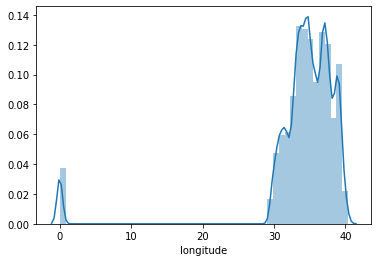

In [414]:
sns.distplot(X_train.longitude);

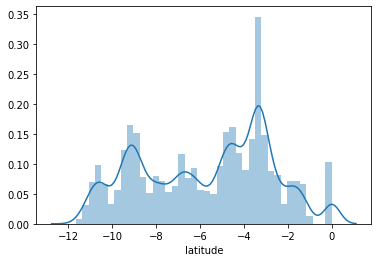

In [415]:
sns.distplot(X_train.latitude);

### `StandardScaler`

In [417]:


logreg = LogisticRegression(random_state=2021)

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('estimator', logreg)])

kfolds = KFold(shuffle=True, random_state=2021)
scores = cross_val_score(pipeline, X_train_master, y_train, scoring='accuracy')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [418]:
scores

array([0.7491297 , 0.73846154, 0.75306008, 0.75527853, 0.74146451])

In [419]:
scores.mean()

0.7474788712641626

Our mean cross validation score has gone up from **55.7%** to **74.75%** just from normalizing. 

I am going to try the same Algorithm (LogisticRegression), but using MinMaxScaler and RobustScaler for comparison.

### `MinMaxScaler`

In [423]:
logreg = LogisticRegression(random_state=2021)

pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('estimator', logreg)])

kfolds = KFold(shuffle=True, random_state=2021)
scores = cross_val_score(pipeline, X_train_master, y_train, scoring='accuracy')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [425]:
scores.mean()

0.7509377536570762

### `RobustScaler`

In [428]:
logreg = LogisticRegression(random_state=2021)

pipeline = Pipeline([('scaler', RobustScaler()),
                     ('estimator', logreg)])

kfolds = KFold(shuffle=True, random_state=2021)
scores = cross_val_score(pipeline, X_train_master, y_train, scoring='accuracy')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [430]:
scores.mean()

0.71778627400236

Among the 3 types of Scaler, MinMaxScaler seems to yield highest average accuracy score in 5 fold cross validation.

## Categorical Feature Selection

### `SelectKbest`

In [432]:
X_train.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'month_recorded',
       'year_recorded', 'age_recorded'],
      dtype='object')

In [444]:
fs = SelectKBest()
fs_fit = fs.fit(X_train_master, y_train)

In [438]:
kbest = pd.DataFrame()
kbest['feature'] = X_train_master.columns
kbest['score'] = fs_fit.scores_

In [446]:
above_100 = kbest[kbest.score >= 100]
len(above_100)

46

In [447]:
above_100.sort_values(by='score', ascending=False)

,feature,score
3586,quantity_dry,4462.079950
3599,waterpoint_type_group_other,2471.612242
3564,extraction_type_class_other,2259.192876
3587,quantity_enough,1563.315431
3561,extraction_type_class_gravity,661.137371
3585,quality_group_unknown,652.532278
3575,payment_type_never pay,638.650685
3574,payment_type_monthly,428.541989
3582,quality_group_good,413.197752
3615,longitude,335.999106


In [450]:
list(above_100.feature.values)

['funder_Dwsp',
 'funder_Fini Water',
 'funder_Germany Republi',
 'funder_Government Of Tanzania',
 'funder_Isf',
 'funder_Norad',
 'funder_Private Individual',
 'installer_CES',
 'installer_Central government',
 'installer_Government',
 'installer_MA',
 'installer_RWE',
 'basin_Lake Nyasa',
 'basin_Rufiji',
 'basin_Ruvuma / Southern Coast',
 'public_meeting_False',
 'public_meeting_True',
 'scheme_management_VWC',
 'scheme_management_WUA',
 'scheme_management_WUG',
 'scheme_management_Water Board',
 'extraction_type_class_gravity',
 'extraction_type_class_handpump',
 'extraction_type_class_motorpump',
 'extraction_type_class_other',
 'payment_type_annually',
 'payment_type_monthly',
 'payment_type_never pay',
 'payment_type_per bucket',
 'payment_type_unknown',
 'quality_group_good',
 'quality_group_unknown',
 'quantity_dry',
 'quantity_enough',
 'quantity_unknown',
 'source_class_groundwater',
 'source_class_surface',
 'waterpoint_type_group_communal standpipe',
 'waterpoint_type_gro

In [451]:
X_train_best46 = X_train_master[list(above_100.feature.values)]

Then I am going to train a LogisticRegression model using these best 46 features to see how far they can go.

In [452]:
logreg = LogisticRegression(random_state=2021)

pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('estimator', logreg)])

kfolds = KFold(shuffle=True, random_state=2021)
scores = cross_val_score(pipeline, X_train_best46, y_train, scoring='accuracy')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [454]:
scores.mean()

0.7210430202401005

In [455]:
X_train_master.shape

(44523, 3624)

**72.1%** is defnitely not a bad score considering I've gone from 3624 features down to 46. Training time has definitely gone down significantly.

Next, I am going to see if extending the limit to 100 features could improve predictive performance of this model.

In [456]:
top_100 = kbest.sort_values(by='score', ascending=False)[:100]

In [459]:
X_train_best100 = X_train_master[list(top_100.feature.values)]

In [460]:
logreg = LogisticRegression(random_state=2021)

pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('estimator', logreg)])

kfolds = KFold(shuffle=True, random_state=2021)
scores = cross_val_score(pipeline, X_train_best100, y_train, scoring='accuracy')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [462]:
scores.mean()

0.7290164070882981

Going from 46 to 100 features only improves average accuracy score by 0.8%, which is probably not worth it. I'll go back down, but maybe keep it at to 50 features.

In [463]:
top_50 = kbest.sort_values(by='score', ascending=False)[:50]
X_train_best50 = X_train_master[list(top_50.feature.values)]

logreg = LogisticRegression(random_state=2021)

pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('estimator', logreg)])

kfolds = KFold(shuffle=True, random_state=2021)
scores = cross_val_score(pipeline, X_train_best50, y_train, scoring='accuracy')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [464]:
scores

array([0.72397529, 0.71611454, 0.72723189, 0.7265274 , 0.71439802])

In [465]:
scores.mean()

0.7216494312280017

Using default `solver='lbfgs'` keeps throwing up warning messages. I'll use GridSearch to experiment with different values for solver to see which one might be performing best.

In [488]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('logreg', LogisticRegression(random_state=2021))])

grid = [{
    'logreg__solver': ['sag', 'saga', 'newton-cg'],
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__max_iter': [100, 500]
}]

gridsearch = GridSearchCV(estimator=pipeline,
                          param_grid=grid,
                          scoring='accuracy',
                          cv=5,
                          verbose=1)

gridsearch.fit(X_train_best50, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logreg',
                                        LogisticRegression(random_state=2021))]),
             param_grid=[{'logreg__C': [0.01, 0.1, 1, 10, 100],
                          'logreg__max_iter': [100, 500],
                          'logreg__solver': ['sag', 'saga', 'newton-cg']}],
             scoring='accuracy', verbose=1)

In [489]:
gridsearch.best_params_

{'logreg__C': 10, 'logreg__max_iter': 100, 'logreg__solver': 'saga'}

In [490]:
gridsearch.best_score_

0.7220537111054945

In [491]:
gridsearch.cv_results_

{'mean_fit_time': array([ 0.74931798,  1.18890171,  1.32455864,  0.65907164,  1.16085596,
         1.31506605,  0.93280883,  1.14468279,  1.8551425 ,  0.9461544 ,
         1.13447113,  1.83154182,  2.25215306,  1.46202617,  2.94032788,
         2.24044547,  1.47933927,  2.85069742,  3.123066  ,  4.21506648,
         4.04154992,  3.13426161,  4.18122692,  4.03986015,  3.92108083,
         5.06283703,  6.30153985,  9.48717532, 12.31982079,  6.25226226]),
 'std_fit_time': array([0.07857249, 0.02741001, 0.04486873, 0.00964795, 0.03565996,
        0.03388918, 0.03211039, 0.01503335, 0.05145691, 0.05052852,
        0.02182589, 0.05088873, 0.20584688, 0.08585957, 0.13378437,
        0.21118163, 0.12129662, 0.12028789, 0.2399233 , 0.07376388,
        0.42720929, 0.26416066, 0.09374893, 0.41186525, 0.05408361,
        0.07088307, 0.45346782, 1.78773756, 0.17092979, 0.4357845 ]),
 'mean_score_time': array([0.01794472, 0.01645513, 0.01671333, 0.01641712, 0.01676612,
        0.0165473 , 0.01626401

### `KNeighborClassifier`

In [494]:
knn = KNeighborsClassifier()

knn_scores = cross_val_score(knn, X_train_best50, y_train, scoring='accuracy')

In [496]:
knn_scores.mean()

0.6788626830177581

In [550]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])

grid = [{
    'knn__n_neighbors': [5, 7, 9, 11, 13, 15],
    'knn__weights': ['uniform', 'distance']
}]

gridsearch_knn = GridSearchCV(estimator=pipeline,
                              param_grid=grid,
                              scoring='accuracy',
                              cv=5)

gridsearch_knn.fit(X_train_best50, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': [5, 7, 9, 11, 13, 15],
                          'knn__weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [551]:
gridsearch_knn.best_params_

{'knn__n_neighbors': 15, 'knn__weights': 'distance'}

In [552]:
gridsearch_knn.best_score_

0.7665251257029249

In [632]:
gridsearch_knn.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

K Nearest Neighbors produces an average accuracy score of **76.65%** which is approx. 4.45% higher than Logistic Regression.

### `DecisionTree`

In [545]:
tree = DecisionTreeClassifier(random_state=2021)

tree_scores = cross_val_score(tree, X_train_best50, y_train, scoring='accuracy')

In [546]:
tree_scores

array([0.73947221, 0.72678271, 0.73767546, 0.73315364, 0.73798293])

In [547]:
tree_scores.mean()

0.7350133888055661

In [622]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('tree', DecisionTreeClassifier(random_state=2021))])

grid = [{
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': [None, 2, 4, 6],
    'tree__min_samples_split': range(50, 100, 150),
    'tree__max_features': ['auto', 'sqrt', 'log2']
}]

gridsearch_tree = GridSearchCV(estimator=pipeline,
                              param_grid=grid,
                              scoring='accuracy',
                              cv=5,
                              return_train_score=True)

gridsearch_tree.fit(X_train_best50, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=2021))]),
             param_grid=[{'tree__criterion': ['gini', 'entropy'],
                          'tree__max_depth': [None, 2, 4, 6],
                          'tree__max_features': ['auto', 'sqrt', 'log2'],
                          'tree__min_samples_split': range(50, 100, 150)}],
             return_train_score=True, scoring='accuracy')

In [623]:
gridsearch_tree.best_params_

{'tree__criterion': 'gini',
 'tree__max_depth': None,
 'tree__max_features': 'auto',
 'tree__min_samples_split': 50}

In [624]:
gridsearch_tree.best_score_

0.7474113193421827

Next, I'll start experimenting with feature engineering and doing something more with the geospatial data to see if we can discover any underlying feature(s).

### Nearest Big City & Distance to Nearest Big City

I've obtained geospatial data and population data for cities in Tanzania from 2 different websites:
- https://simplemaps.com/data/tz-cities
- https://worldpopulationreview.com/countries/cities/tanzania

I'll merge them and then I'll proceed to calculate the distance between our wells to these cities to identify nearest big cities - any city with a population above 100,000 (This 100,000 benchmark is arbitrary).

In [542]:
tanzania_cities = pd.read_csv('data/tz.csv')
tanzania_cities.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Dar es Salaam,-6.8000,39.2833,Tanzania,TZ,Dar es Salaam,primary,6698000.0,4364541.0
1,Arusha,-3.3667,36.6833,Tanzania,TZ,Arusha,admin,416442.0,416442.0
2,Dodoma,-6.2500,35.7500,Tanzania,TZ,Dodoma,primary,410956.0,410956.0
3,Mwanza,-2.5167,32.9000,Tanzania,TZ,Mwanza,admin,385810.0,385810.0
4,Mbeya,-8.9000,33.4500,Tanzania,TZ,Mbeya,admin,291649.0,232062.0


In [535]:
tanzania_pop = pd.read_csv('data/csvData.csv')
tanzania_pop = tanzania_pop[['name', '2021']]
tanzania_pop.columns = ['city', 'population_2021']
tanzania_pop.head(10)

,city,population_2021
0,Dar es Salaam,2698652
1,Mwanza,436801
2,Zanzibar,403658
3,Arusha,341136
4,Mbeya,291649
5,Morogoro,250902
6,Tanga,224876
7,Dodoma,180541
8,Kigoma,164268
9,Moshi,156959


In [538]:
tz_df = tanzania_pop.merge(tanzania_cities, how='left', left_on='city', right_on='city')
tz_df.head()

,city,population_2021,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Dar es Salaam,2698652,-6.8000,39.2833,Tanzania,TZ,Dar es Salaam,primary,6698000.0,4364541.0
1,Mwanza,436801,-2.5167,32.9000,Tanzania,TZ,Mwanza,admin,385810.0,385810.0
2,Zanzibar,403658,-6.1667,39.2000,Tanzania,TZ,Zanzibar Urban/West,admin,205870.0,205870.0
3,Arusha,341136,-3.3667,36.6833,Tanzania,TZ,Arusha,admin,416442.0,416442.0
4,Mbeya,291649,-8.9000,33.4500,Tanzania,TZ,Mbeya,admin,291649.0,232062.0


In [540]:
# drop the 2 population columns from the first df because they seem incorrect
tz_df.drop(['population', 'population_proper'], axis=1, inplace=True)

In [555]:
# create another column that store the coordinates as a tuple
tz_df['coordinates'] = list(zip(tz_df.lat, tz_df.lng))

In [557]:
tz_df.head()

,city,population_2021,lat,lng,country,iso2,admin_name,capital,coordinates
0,Dar es Salaam,2698652,-6.8000,39.2833,Tanzania,TZ,Dar es Salaam,primary,"(-6.8, 39.2833)"
1,Mwanza,436801,-2.5167,32.9000,Tanzania,TZ,Mwanza,admin,"(-2.5167, 32.9)"
2,Zanzibar,403658,-6.1667,39.2000,Tanzania,TZ,Zanzibar Urban/West,admin,"(-6.1667, 39.2)"
3,Arusha,341136,-3.3667,36.6833,Tanzania,TZ,Arusha,admin,"(-3.3667, 36.6833)"
4,Mbeya,291649,-8.9000,33.4500,Tanzania,TZ,Mbeya,admin,"(-8.9, 33.45)"


In [558]:
# select cities with population > 100,000
tz_pop_above100k = tz_df[tz_df.population_2021 > 100000].copy()

In [576]:
tz_pop_above100k.dropna(subset=['lat', 'lng'], inplace=True)

In [ ]:
# !pip install geopy

In [571]:
def closest_point(x):
    output = None
    for _, city in tz_pop_above100k.iterrows():
        distance = geodesic(x, city.coordinates).km
        city_name = city.city
        if (output is None) or (distance < output[1]):
            output = (city_name, distance)
    return output

In [578]:
closest_point((-7.106400, 35.978005))

('Iringa', 79.97978760542934)

In [579]:
tz_pop_above100k

,city,population_2021,lat,lng,country,iso2,admin_name,capital,coordinates
0,Dar es Salaam,2698652,-6.8000,39.2833,Tanzania,TZ,Dar es Salaam,primary,"(-6.8, 39.2833)"
1,Mwanza,436801,-2.5167,32.9000,Tanzania,TZ,Mwanza,admin,"(-2.5167, 32.9)"
2,Zanzibar,403658,-6.1667,39.2000,Tanzania,TZ,Zanzibar Urban/West,admin,"(-6.1667, 39.2)"
3,Arusha,341136,-3.3667,36.6833,Tanzania,TZ,Arusha,admin,"(-3.3667, 36.6833)"
4,Mbeya,291649,-8.9000,33.4500,Tanzania,TZ,Mbeya,admin,"(-8.9, 33.45)"
5,Morogoro,250902,-6.8242,37.6633,Tanzania,TZ,Morogoro,admin,"(-6.8242, 37.6633)"
6,Tanga,224876,-5.0667,39.1000,Tanzania,TZ,Tanga,admin,"(-5.0667, 39.1)"
7,Dodoma,180541,-6.2500,35.7500,Tanzania,TZ,Dodoma,primary,"(-6.25, 35.75)"
8,Kigoma,164268,-4.8833,29.6333,Tanzania,TZ,Kigoma,admin,"(-4.8833, 29.6333)"
9,Moshi,156959,-3.3349,37.3404,Tanzania,TZ,Kilimanjaro,admin,"(-3.3349, 37.3404)"


#### Create new columns 

In [584]:
X_train['coordinates'] = list(zip(X_train.latitude, X_train.longitude))

In [586]:
X_train['nearest_big_city'] = X_train['coordinates'].apply(lambda x: closest_point(x)[0])

In [588]:
X_train['distance_to_nearest_big_city'] = X_train['coordinates'].apply(lambda x: closest_point(x)[1])

In [589]:
X_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,source_type,source_class,waterpoint_type,waterpoint_type_group,month_recorded,year_recorded,age_recorded,coordinates,nearest_big_city,distance_to_nearest_big_city
9307,0.0,2011-03-31,Government Of Tanzania,0,Gover,35.978005,-7.106400,Mtera Dam Secondary School,0,Rufiji,...,borehole,groundwater,communal standpipe,communal standpipe,Mar,2011,2011,"(-7.10639972, 35.97800484)",Iringa,79.979809
49793,250.0,2013-01-31,Government Of Tanzania,1269,DWE,30.042428,-4.723325,Kwa Omary,0,Lake Tanganyika,...,river/lake,surface,communal standpipe,communal standpipe,Jan,2013,14,"(-4.72332456, 30.04242772)",Kigoma,48.710862
23531,20.0,2011-03-01,Jica,5,KONOIKE,38.609061,-6.866249,Muhanga,0,Wami / Ruvu,...,river/lake,surface,communal standpipe,communal standpipe,Mar,2011,2,"(-6.86624922, 38.60906092)",Dar es Salaam,74.885600
46666,50.0,2013-05-03,World Vision,1321,Naishu Construction Co. ltd,36.581420,-3.453983,Mlimani Farm,0,Pangani,...,borehole,groundwater,communal standpipe multiple,communal standpipe,May,2013,1,"(-3.45398308, 36.58142018)",Arusha,14.876976
46034,0.0,2011-08-02,Government Of Tanzania,0,Government,33.387871,-2.611837,Office Ya Ccm,0,Lake Victoria,...,borehole,groundwater,communal standpipe multiple,communal standpipe,Aug,2011,2011,"(-2.61183706, 33.38787065)",Mwanza,55.265963


In [594]:
tz_pop_above100k[tz_pop_above100k.city == 'Arusha'].population_2021.values[0]

341136

In [595]:
X_train['nearest_big_city_pop'] = X_train['nearest_big_city'].apply\
             (lambda x: tz_pop_above100k[tz_pop_above100k.city == 'Arusha'].population_2021.values[0])

In [597]:
X_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,source_class,waterpoint_type,waterpoint_type_group,month_recorded,year_recorded,age_recorded,coordinates,nearest_big_city,distance_to_nearest_big_city,nearest_big_city_pop
9307,0.0,2011-03-31,Government Of Tanzania,0,Gover,35.978005,-7.106400,Mtera Dam Secondary School,0,Rufiji,...,groundwater,communal standpipe,communal standpipe,Mar,2011,2011,"(-7.10639972, 35.97800484)",Iringa,79.979809,341136
49793,250.0,2013-01-31,Government Of Tanzania,1269,DWE,30.042428,-4.723325,Kwa Omary,0,Lake Tanganyika,...,surface,communal standpipe,communal standpipe,Jan,2013,14,"(-4.72332456, 30.04242772)",Kigoma,48.710862,341136
23531,20.0,2011-03-01,Jica,5,KONOIKE,38.609061,-6.866249,Muhanga,0,Wami / Ruvu,...,surface,communal standpipe,communal standpipe,Mar,2011,2,"(-6.86624922, 38.60906092)",Dar es Salaam,74.885600,341136
46666,50.0,2013-05-03,World Vision,1321,Naishu Construction Co. ltd,36.581420,-3.453983,Mlimani Farm,0,Pangani,...,groundwater,communal standpipe multiple,communal standpipe,May,2013,1,"(-3.45398308, 36.58142018)",Arusha,14.876976,341136
46034,0.0,2011-08-02,Government Of Tanzania,0,Government,33.387871,-2.611837,Office Ya Ccm,0,Lake Victoria,...,groundwater,communal standpipe multiple,communal standpipe,Aug,2011,2011,"(-2.61183706, 33.38787065)",Mwanza,55.265963,341136


In [603]:
# drop some columns off of X_train again
X_train3 = X_train.drop(['subvillage', 'scheme_name', 'wpt_name', 'region',
                         'lga', 'ward', 'extraction_type', 'extraction_type_group', 'management',
                         'payment', 'water_quality', 'source', 'source_type',
                         'waterpoint_type', 'date_recorded', 'coordinates'], axis=1).copy()

In [604]:
# select categorical columns from all df3 columns
categorical = X_train3.select_dtypes(include=[object])
cat_cols = categorical.columns

In [605]:
categorical.head()

,funder,installer,basin,public_meeting,scheme_management,permit,extraction_type_class,management_group,payment_type,quality_group,quantity,source_class,waterpoint_type_group,month_recorded,nearest_big_city
9307,Government Of Tanzania,Gover,Rufiji,True,VWC,True,submersible,user-group,monthly,salty,enough,groundwater,communal standpipe,Mar,Iringa
49793,Government Of Tanzania,DWE,Lake Tanganyika,True,Water authority,True,gravity,user-group,monthly,good,enough,surface,communal standpipe,Jan,Kigoma
23531,Jica,KONOIKE,Wami / Ruvu,True,VWC,True,motorpump,user-group,per bucket,good,enough,surface,communal standpipe,Mar,Dar es Salaam
46666,World Vision,Naishu Construction Co. ltd,Pangani,True,WUA,True,submersible,user-group,per bucket,good,enough,groundwater,communal standpipe,May,Arusha
46034,Government Of Tanzania,Government,Lake Victoria,True,VWC,False,motorpump,user-group,per bucket,good,enough,groundwater,communal standpipe,Aug,Mwanza


In [606]:
ohe = OneHotEncoder(handle_unknown='ignore')
cat_encoded = ohe.fit_transform(categorical)
columns = ohe.get_feature_names(cat_cols)

cat_ohe = pd.DataFrame(cat_encoded.todense(), columns=columns)
cat_ohe.head()

,funder_0,funder_A/co Germany,funder_Aar,funder_Abas Ka,funder_Abasia,funder_Abc-ihushi Development Cent,funder_Abd,funder_Abdala,funder_Abddwe,funder_Abdul,...,nearest_big_city_Mbeya,nearest_big_city_Morogoro,nearest_big_city_Moshi,nearest_big_city_Musoma,nearest_big_city_Mwanza,nearest_big_city_Shinyanga,nearest_big_city_Songea,nearest_big_city_Tabora,nearest_big_city_Tanga,nearest_big_city_Zanzibar
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [607]:
cont = X_train3.select_dtypes(exclude=[object]).reset_index()

In [608]:
X_train_master2 = pd.concat([cat_ohe, cont], axis=1)

In [609]:
X_train_master2.head()

,funder_0,funder_A/co Germany,funder_Aar,funder_Abas Ka,funder_Abasia,funder_Abc-ihushi Development Cent,funder_Abd,funder_Abdala,funder_Abddwe,funder_Abdul,...,latitude,num_private,region_code,district_code,population,construction_year,year_recorded,age_recorded,distance_to_nearest_big_city,nearest_big_city_pop
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.106400,0,1,1,0,0,2011,2011,79.979809,341136
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.723325,0,16,2,420,1999,2013,14,48.710862,341136
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.866249,0,6,2,150,2009,2011,2,74.885600,341136
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.453983,0,2,2,800,2012,2013,1,14.876976,341136
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.611837,0,19,2,0,0,2011,2011,55.265963,341136


In [660]:
X_train_master2.to_pickle('data/X_train_master2.pkl')

In [661]:
y_train.to_pickle('data/y_train.pkl')
X_test.to_pickle('data/X_test.pkl')
y_test.to_pickle('data/y_test.pkl')

In [610]:
fs = SelectKBest()
fs_fit = fs.fit(X_train_master2, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [3640] are constant.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [611]:
kbest2 = pd.DataFrame()
kbest2['feature'] = X_train_master2.columns
kbest2['score'] = fs_fit.scores_

In [614]:
above100 = kbest2[kbest2.score >= 100].sort_values(by='score', ascending=False)
len(above100)

49

In [669]:
above100

,feature,score
3586,quantity_dry,4462.079950
3599,waterpoint_type_group_other,2471.612242
3564,extraction_type_class_other,2259.192876
3587,quantity_enough,1563.315431
3561,extraction_type_class_gravity,661.137371
3585,quality_group_unknown,652.532278
3575,payment_type_never pay,638.650685
3616,nearest_big_city_Kigoma,519.376806
3574,payment_type_monthly,428.541989
3582,quality_group_good,413.197752


In [629]:
kbest50_2 = kbest2.sort_values(by='score', ascending=False)[:50].feature.values
kbest50_2

array(['quantity_dry', 'waterpoint_type_group_other',
       'extraction_type_class_other', 'quantity_enough',
       'extraction_type_class_gravity', 'quality_group_unknown',
       'payment_type_never pay', 'nearest_big_city_Kigoma',
       'payment_type_monthly', 'quality_group_good', 'longitude',
       'gps_height', 'funder_Government Of Tanzania', 'region_code',
       'extraction_type_class_handpump', 'payment_type_per bucket',
       'waterpoint_type_group_communal standpipe',
       'payment_type_annually', 'payment_type_unknown',
       'month_recorded_Jan', 'basin_Ruvuma / Southern Coast',
       'month_recorded_Mar', 'waterpoint_type_group_hand pump',
       'source_class_surface', 'scheme_management_VWC',
       'source_class_groundwater', 'distance_to_nearest_big_city',
       'funder_Dwsp', 'extraction_type_class_motorpump',
       'scheme_management_Water Board', 'installer_Government',
       'funder_Isf', 'nearest_big_city_Arusha', 'installer_RWE',
       'scheme_mana

In [616]:
set(above100.feature) - set(above_100.feature)

{'distance_to_nearest_big_city',
 'nearest_big_city_Arusha',
 'nearest_big_city_Kigoma'}

Adding 3 features `nearest_big_city`, `distance_to_nearest_big_city` and `nearest_big_city_pop` has brought 3 more features into the list of features with scores above 100. I'd take that as a win! 

In [618]:
set(X_train_best50.columns) - set(above100.feature) 

{'basin_Lake Tanganyika',
 'funder_Fw',
 'installer_FW',
 'scheme_management_Water authority'}

In [621]:
kbest2[kbest2.feature.isin(['basin_Lake Tanganyika','funder_Fw','installer_FW','scheme_management_Water authority'])]

,feature,score
372,funder_Fw,84.956798
2091,installer_FW,84.956798
3536,basin_Lake Tanganyika,87.951314
3557,scheme_management_Water authority,83.863770


In [631]:
X_train_best50_2 = X_train_master2[kbest50_2]

In [662]:
X_train_best50_2.to_pickle('data/X_train_best50_2.pkl')

In [634]:
X_train_best50_2.head()

,quantity_dry,waterpoint_type_group_other,extraction_type_class_other,quantity_enough,extraction_type_class_gravity,quality_group_unknown,payment_type_never pay,nearest_big_city_Kigoma,payment_type_monthly,quality_group_good,...,public_meeting_False,installer_Central government,basin_Rufiji,basin_Lake Nyasa,funder_Germany Republi,installer_CES,funder_Private Individual,funder_Norad,installer_MA,basin_Lake Tanganyika
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [635]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])

grid = [{
    'knn__n_neighbors': [5, 7, 9, 11, 13, 15],
    'knn__weights': ['uniform', 'distance']
}]

gridsearch_knn2 = GridSearchCV(estimator=pipeline,
                              param_grid=grid,
                              scoring='accuracy',
                              cv=5)

gridsearch_knn2.fit(X_train_best50_2, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': [5, 7, 9, 11, 13, 15],
                          'knn__weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [636]:
gridsearch_knn2.best_score_

0.7723872961725875

In [637]:
gridsearch_knn2.best_params_

{'knn__n_neighbors': 15, 'knn__weights': 'distance'}

In [654]:
# create a function that prints out accuracy report and returns accuracy score
# for cross_val_score


def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

scoring = make_scorer(classification_report_with_accuracy_score)

In [655]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('knn', KNeighborsClassifier(n_neighbors=15, weights='distance'))])

scores = cross_val_score(pipeline, X_train_best50_2, y_train, scoring=scoring)
print(scores)

                         precision    recall  f1-score   support

             functional       0.79      0.84      0.82      4830
functional needs repair       0.47      0.34      0.39       646
         non functional       0.79      0.76      0.77      3429

               accuracy                           0.77      8905
              macro avg       0.69      0.65      0.66      8905
           weighted avg       0.77      0.77      0.77      8905

                         precision    recall  f1-score   support

             functional       0.78      0.86      0.82      4830
functional needs repair       0.47      0.33      0.38       646
         non functional       0.79      0.73      0.76      3429

               accuracy                           0.77      8905
              macro avg       0.68      0.64      0.65      8905
           weighted avg       0.76      0.77      0.77      8905

                         precision    recall  f1-score   support

             funct

As of now the performance of our model on `functional needs repair` class is still very low, which is understandable as this class is underrepresented in the dataset compared to the other 2. I'll try to use SMOTE in the next pipeline to see if that would increase the performance.

In [ ]:
# Somehow could not get imblearn into learn-env, so I'm going to bring the dataset outside to
# run them in python3

In [ ]:
# from imblearn.over_sampling import SMOTE

# pipeline = Pipeline([('sampling', SMOTE(random_state=2021))
#                      ('scaler', MinMaxScaler()),
#                      ('knn', KNeighborsClassifier(n_neighbors=15, weights='distance'))])

# scores = cross_val_score(pipeline, X_train_best50_2, y_train, scoring=scoring)
# print(scores)

### `XGBoost`

In [651]:
scores

array([nan, nan, nan, nan, nan])

In [642]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('xgb', XGBClassifier())])

scores = cross_val_score(pipeline, X_train_best50_2, y_train, scoring='accuracy')

In [644]:
scores.mean()

0.73422720005973

Hyperparameter Tuning for XGBoost:

In [ ]:
# Taking a very long time

In [ ]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('xgb', XGBClassifier())])

grid = [{'xgb__learning_rate': [0.01, 0.1],
#          'xgb__max_depth': [3, 5, 7, 10],
#          'xgb__min_child_weight': [1, 3, 5],
#          'xgb__subsample': [0.5, 0.7],
#          'xgb__colsample_bytree': [0.5, 0.7],
         'xgb__n_estimators' : [100, 200, 500]
    }]

gridsearch_xgb = GridSearchCV(estimator=pipeline,
                              param_grid=grid,
                              scoring='accuracy',
                              cv=5,
                              verbose=1)

gridsearch_xgb.fit(X_train_best50_2, y_train)